In [1]:
from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
from keras.layers.merge import dot, add, concatenate

Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX TITAN X (0000:04:00.0)
Using Theano backend.


In [2]:
path = "data/ml-latest-small/"  # from https://grouplens.org/datasets/movielens/
#path = "data/ml-20m/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64
#batch_size=1

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [5]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict

In [6]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [7]:
# userId and movieId become ditionary elements with values ranging from 0 to max len 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [8]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [9]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [10]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [11]:
n_factors = 50

In [12]:
np.random.seed = 42

Randomly split into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [14]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [15]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [16]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [17]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [18]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [19]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(input_dim=n_users, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(input_dim=n_movies, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [20]:
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/1
79985/79985 [==============================] - 2s 20us/step - loss: 9.8956 - val_loss: 4.3525


In [22]:
model.optimizer.lr=0.01

In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/3
79985/79985 [==============================] - 1s 12us/step - loss: 3.1380 - val_loss: 2.8398
Epoch 2/3
79985/79985 [==============================] - 1s 13us/step - loss: 2.3949 - val_loss: 2.6146
Epoch 3/3
79985/79985 [==============================] - 1s 12us/step - loss: 2.2168 - val_loss: 2.5681


In [24]:
model.optimizer.lr=0.001

In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/6
79985/79985 [==============================] - 1s 12us/step - loss: 2.1489 - val_loss: 2.5543
Epoch 2/6
79985/79985 [==============================] - 1s 15us/step - loss: 2.1146 - val_loss: 2.5583
Epoch 3/6
79985/79985 [==============================] - 1s 12us/step - loss: 2.0897 - val_loss: 2.5565
Epoch 4/6
79985/79985 [==============================] - 1s 12us/step - loss: 2.0682 - val_loss: 2.5664
Epoch 5/6
79985/79985 [==============================] - 1s 12us/step - loss: 2.0503 - val_loss: 2.5844
Epoch 6/6
79985/79985 [==============================] - 1s 12us/step - loss: 2.0326 - val_loss: 2.5833


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [26]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [27]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [28]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [29]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [30]:
x = dot([u, m], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [31]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/1
79985/79985 [==============================] - 1s 17us/step - loss: 8.9321 - val_loss: 3.6368


In [32]:
model.optimizer.lr=0.01

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/6
79985/79985 [==============================] - 1s 17us/step - loss: 2.6042 - val_loss: 2.3201
Epoch 2/6
79985/79985 [==============================] - 1s 17us/step - loss: 1.9748 - val_loss: 2.1060
Epoch 3/6
79985/79985 [==============================] - 1s 17us/step - loss: 1.8088 - val_loss: 2.0151
Epoch 4/6
79985/79985 [==============================] - 1s 17us/step - loss: 1.7148 - val_loss: 1.9415
Epoch 5/6
79985/79985 [==============================] - 1s 17us/step - loss: 1.6381 - val_loss: 1.8740
Epoch 6/6
79985/79985 [==============================] - 1s 17us/step - loss: 1.5650 - val_loss: 1.8116


In [34]:
model.optimizer.lr=0.001

In [35]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/10
79985/79985 [==============================] - 1s 18us/step - loss: 1.4941 - val_loss: 1.7462
Epoch 2/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.4261 - val_loss: 1.6897
Epoch 3/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.3599 - val_loss: 1.6368
Epoch 4/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.2955 - val_loss: 1.5780
Epoch 5/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.2325 - val_loss: 1.5279
Epoch 6/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.1740 - val_loss: 1.4788
Epoch 7/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.1176 - val_loss: 1.4343
Epoch 8/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.0635 - val_loss: 1.3888
Epoch 9/10
79985/79985 [==============================] - 1s 17us/step - loss: 1.0127 - val_loss: 1.3486
Epoch

In [36]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/5
79985/79985 [==============================] - 1s 17us/step - loss: 0.9183 - val_loss: 1.2728
Epoch 2/5
79985/79985 [==============================] - 1s 17us/step - loss: 0.8753 - val_loss: 1.2377
Epoch 3/5
79985/79985 [==============================] - 1s 17us/step - loss: 0.8358 - val_loss: 1.2065
Epoch 4/5
79985/79985 [==============================] - 1s 17us/step - loss: 0.7989 - val_loss: 1.1807
Epoch 5/5
79985/79985 [==============================] - 1s 17us/step - loss: 0.7647 - val_loss: 1.1574


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [37]:
model.save_weights(model_path+'bias.h5')

In [38]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [39]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.7951]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [40]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [41]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names()[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [42]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.5381313, 'Battlefield Earth (2000)'),
 (-0.35863543, 'Twilight (2008)'),
 (-0.082414463, 'Little Nicky (2000)'),
 (-0.078536652, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.055510294, 'Super Mario Bros. (1993)'),
 (-0.052326858, 'Spice World (1997)'),
 (-0.031911273, 'Scooby-Doo (2002)'),
 (-0.019748485, 'Wild Wild West (1999)'),
 (-0.010791404, 'Speed 2: Cruise Control (1997)'),
 (-0.0066003338, 'Jaws 3-D (1983)'),
 (0.016157528, 'Police Academy 6: City Under Siege (1989)'),
 (0.033731937, 'Batman & Robin (1997)'),
 (0.061739374, 'Blue Lagoon, The (1980)'),
 (0.068384483, 'Haunting, The (1999)'),
 (0.071630701, 'Bedazzled (2000)')]

In [43]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3901581, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3584974, '3:10 to Yuma (2007)'),
 (1.3426175, 'You Can Count on Me (2000)'),
 (1.3396636, 'Tom Jones (1963)'),
 (1.3320545, 'Rush (2013)'),
 (1.3302625, 'Argo (2012)'),
 (1.3199012, 'Harry Potter and the Deathly Hallows: Part 2 (2011)'),
 (1.317217, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.3063253, 'Exotica (1994)'),
 (1.3040084, 'Frankenstein (1931)'),
 (1.2874012, 'Shawshank Redemption, The (1994)'),
 (1.2871125, 'Big Night (1996)'),
 (1.2730958, 'Gold Rush, The (1925)'),
 (1.264116, 'Smoke (1995)'),
 (1.2613045, 'Cyrano de Bergerac (1990)')]

We can now do the same thing for the embeddings.

In [44]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [46]:
fac0 = movie_pca[0]

In [47]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.054738887, "Schindler's List (1993)"),
 (0.054511167, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.05379381, 'Usual Suspects, The (1995)'),
 (0.05215532, 'Shawshank Redemption, The (1994)'),
 (0.051892109,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (0.0514783, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.051051006, 'Silence of the Lambs, The (1991)'),
 (0.050139789, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.05013651, 'Braveheart (1995)'),
 (0.049819216, 'Star Wars: Episode VI - Return of the Jedi (1983)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.011735201, 'Anaconda (1997)'),
 (-0.0093498072, 'Blade: Trinity (2004)'),
 (-0.0075299889, 'Fantastic Four (2005)'),
 (-0.0068901367, "You Don't Mess with the Zohan (2008)"),
 (-0.0067116637, 'Stepford Wives, The (1975)'),
 (-0.0066468255, 'Twilight (2008)'),
 (-0.0066451672, 'Police Academy 6: City Under Siege (1989)'),
 (-0.0065139136, 'Nutty Professor II: The Klumps (2000)'),
 (-0.0064688111, 'RoboCop 3 (1993)'),
 (-0.0064424551, 'House on Haunted Hill (1999)')]

In [50]:
fac1 = movie_pca[1]

In [51]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10817767, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.095548972, 'Armageddon (1998)'),
 (0.083734863, 'Jurassic Park (1993)'),
 (0.081459202, 'Star Trek: Generations (1994)'),
 (0.080764316, 'Stargate (1994)'),
 (0.079325877, 'Ghost (1990)'),
 (0.077736892, 'Waterworld (1995)'),
 (0.077609561, 'Outbreak (1995)'),
 (0.075260721, 'Speed (1994)'),
 (0.074800998, 'Twister (1996)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.063058123, 'City Lights (1931)'),
 (-0.05967832, 'Chinatown (1974)'),
 (-0.0593412, 'Harold and Maude (1971)'),
 (-0.058687616, 'Annie Hall (1977)'),
 (-0.056041334, 'Clockwork Orange, A (1971)'),
 (-0.053652611, 'Brokeback Mountain (2005)'),
 (-0.052994128, '8 1/2 (8½) (1963)'),
 (-0.052201677, 'Room with a View, A (1986)'),
 (-0.051414791, 'Wild Bunch, The (1969)'),
 (-0.050989941, 'Paradise Lost: The Child Murders at Robin Hood Hills (1996)')]

In [54]:
fac2 = movie_pca[2]

In [55]:
movie_comp = [(f, movie_names()[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.066416912, 'Tangled (2010)'),
 (0.064112566, 'Hannibal (2001)'),
 (0.063082337, 'Shrek 2 (2004)'),
 (0.062331878, 'Italian Job, The (2003)'),
 (0.061664376, 'My Fair Lady (1964)'),
 (0.060994055, 'Legally Blonde (2001)'),
 (0.059408564, 'Harry Potter and the Chamber of Secrets (2002)'),
 (0.057092581, 'Harry Potter and the Order of the Phoenix (2007)'),
 (0.055962246, 'Rocky (1976)'),
 (0.053280842, 'Serenity (2005)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.12465727, 'Fargo (1996)'),
 (-0.10523678, 'Silence of the Lambs, The (1991)'),
 (-0.086461805, 'Pulp Fiction (1994)'),
 (-0.086280465, 'Leaving Las Vegas (1995)'),
 (-0.080830812, 'Braveheart (1995)'),
 (-0.07874088, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.077596188, 'Fugitive, The (1993)'),
 (-0.072506294, 'Taxi Driver (1976)'),
 (-0.07083647, "Schindler's List (1993)"),
 (-0.069852732, 'Waterworld (1995)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [58]:
# The following would be for Python 2 only
# reload(sys)
# sys.setdefaultencoding('utf8')

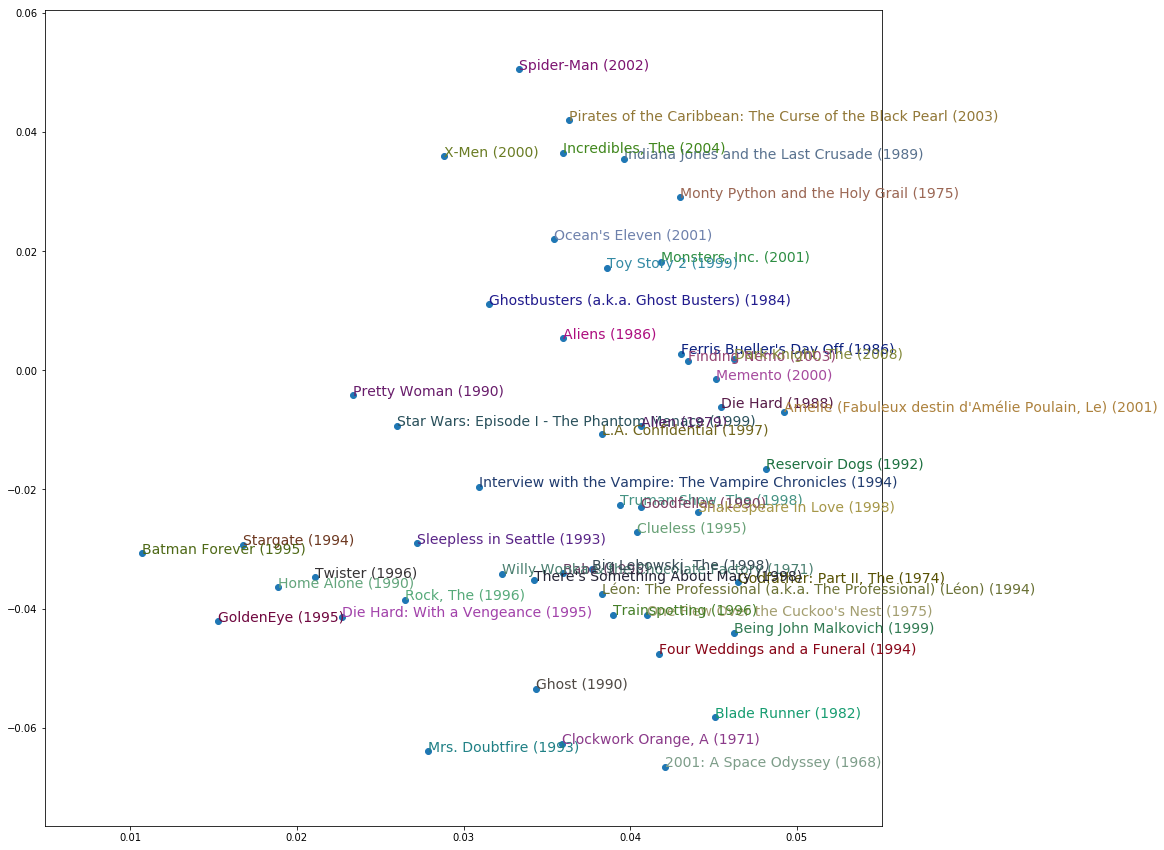

In [59]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [60]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [61]:
x = concatenate([u, m], axis=2)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [62]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79985 samples, validate on 20019 samples
Epoch 1/8
79985/79985 [==============================] - 2s 23us/step - loss: 2.6453 - val_loss: 0.9437
Epoch 2/8
79985/79985 [==============================] - 2s 20us/step - loss: 1.5459 - val_loss: 0.8936
Epoch 3/8
79985/79985 [==============================] - 1s 19us/step - loss: 1.2532 - val_loss: 0.8817
Epoch 4/8
79985/79985 [==============================] - 1s 19us/step - loss: 1.0400 - val_loss: 0.8684
Epoch 5/8
79985/79985 [==============================] - 1s 19us/step - loss: 0.9113 - val_loss: 0.8538
Epoch 6/8
79985/79985 [==============================] - 1s 19us/step - loss: 0.8459 - val_loss: 0.8414
Epoch 7/8
79985/79985 [==============================] - 2s 19us/step - loss: 0.8183 - val_loss: 0.8400
Epoch 8/8
79985/79985 [==============================] - 2s 19us/step - loss: 0.8070 - val_loss: 0.8399


This improves on our already impressive accuracy even further!